## Automatización de la evaluación
¿Qué estrategia utilizarías para explicar o demostrar el comportamiento distinto del modelo a lo largo del tiempo?

In [2]:
import pandas as pd
import numpy as np
import os
import sys

# Agregar src al path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from modeling.predict import evaluate_model
from features.build_features import preprocess
from modeling.predict import load_model
from sklearn.metrics import f1_score

### 1. Carga y evaluación del modelo en múltiples meses
- Selecciona al menos tres meses distintos (por ejemplo: enero, febrero y marzo de 2020).
- Evalúa el modelo entrenado (en enero) sobre cada conjunto mensual por separado.
- Calcula y reporta la métrica F1-score (u otra, si lo consideras apropiado).

In [4]:
model_path = os.path.join(os.getcwd(), "..", "models", "random_forest_model.joblib")
model = load_model(model_path)

#### Evaluación mensual del modelo

In [14]:
def evaluar_meses(meses_urls, model, target_col="high_tip"):
    resultados = []

    for mes, url in meses_urls.items():
        print(f"Evaluando mes: {mes}")

        # Cargar y procesar datos
        df_mes = pd.read_parquet(url)
        df_procesado = preprocess(df=df_mes, target_col=target_col)

        # Usar solo las columnas vistas en entrenamiento
        X_test = df_procesado[model.feature_names_in_]
        y_test = (df_procesado[target_col] > 0).astype(int)

        # Evaluar modelo
        f1 = evaluate_model(model, X_test, y_test)

        # Guardar resultados
        resultados.append({
            "Mes": mes,
            "Ejemplos": len(df_procesado),
            "F1-score": round(f1, 4)
        })

    return pd.DataFrame(resultados)


### 2. Automatización de la evaluación
- Crea una función o script que automatice la evaluación para varios meses.
- 
Organiza los resultados en una tabla con columnas como: mes, cantidad de ejemplos, F1-score.

In [16]:
meses_urls = {
    "Febrero 2020": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet",
    "Marzo 2020": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-03.parquet",
    "Abril 2020": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet",
    "Mayo 2020": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-05.parquet",
    "Junio 2020": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-06.parquet",
    "Julio 2020": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-07.parquet",
    "Agosto 2020": "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-08.parquet"
}


In [18]:
resultados_df = evaluar_meses(meses_urls, model, target_col="high_tip")
display(resultados_df)

Evaluando mes: Febrero 2020
Evaluando mes: Marzo 2020
Evaluando mes: Abril 2020
Evaluando mes: Mayo 2020
Evaluando mes: Junio 2020
Evaluando mes: Julio 2020
Evaluando mes: Agosto 2020


,Mes,Ejemplos,F1-score
0,Febrero 2020,6276854,0.7350
1,Marzo 2020,2995357,0.7258
2,Abril 2020,236611,0.6120
3,Mayo 2020,346612,0.6167
4,Junio 2020,546843,0.6477
5,Julio 2020,796346,0.6662
6,Agosto 2020,1001832,0.6808


### 3. Visualización y análisis
- Representa los resultados mediante un gráfico (línea o barras).
- 
Identifica patrones o anomalías en el rendimiento mensual.

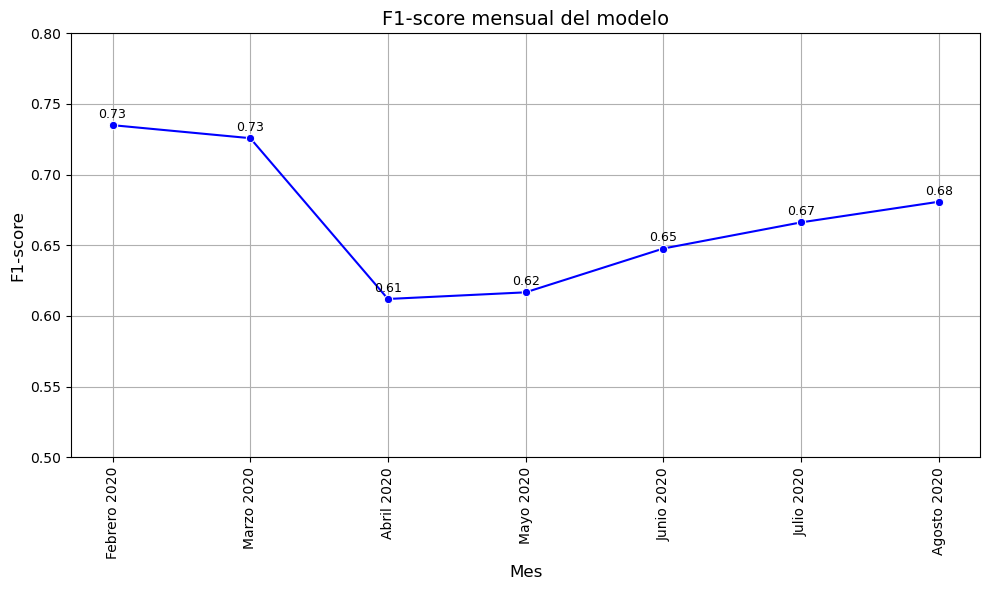

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Asegurarnos de que el orden de los meses sea correcto
resultados_df["Mes"] = pd.Categorical(resultados_df["Mes"], categories=resultados_df["Mes"], ordered=True)

# Crear figura
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico de línea
sns.lineplot(data=resultados_df, x="Mes", y="F1-score", marker="o", ax=ax, color='blue')

# Agregar etiquetas de valor en cada punto
for i, row in resultados_df.iterrows():
    ax.text(i, row["F1-score"] + 0.005, f'{row["F1-score"]:.2f}', ha='center', fontsize=9)

# Estética del gráfico
ax.set_title("F1-score mensual del modelo", fontsize=14)
ax.set_xlabel("Mes", fontsize=12)
ax.set_ylabel("F1-score", fontsize=12)
plt.xticks(rotation=90)
ax.set_ylim(0.5, 0.8)
ax.grid(True)
plt.tight_layout()

# Guardar figura en carpeta correcta
ruta_figuras = r"C:\Users\raval\Dropbox\Magister Data Science\5TRIMESTRE\Desarrollo_Proyectos_y_Productos_Datos\Tarea_01\nyc_tips_classifier\reports\figures"
os.makedirs(ruta_figuras, exist_ok=True)
ruta_guardado = os.path.join(ruta_figuras, "f1_score_mensual.png")
fig.savefig(ruta_guardado, dpi=300)

# Mostrar también en notebook
plt.show()

### 4. Análisis crítico y explicación de resultados
- ¿El modelo mantiene un rendimiento consistente?
- ¿Qué factores podrían explicar la variación en el desempeño?
- ¿Qué acciones recomendarías para mejorar la robustez del modelo en el tiempo?

#### ¿El modelo mantiene un rendimiento consistente?
No. El modelo presenta variaciones significativas en el F1-score a lo largo de los meses evaluados. El rendimiento parte alto en febrero y marzo (≈ 0.73), pero cae abruptamente en abril (0.61), para luego recuperarse gradualmente hasta agosto (0.68).

- Análisis de la tendencia del F1-score: Se ajustó una regresión lineal simple entre los meses (codificados como variable ordinal) y el F1-score para evaluar si hay una tendencia sistemática:

#### ¿Qué factores podrían explicar la variación en el desempeño?
- Cambio en el comportamiento de los usuarios: abril coincide con inicio de cuarentenas por COVID-19 en NYC, lo que pudo alterar la frecuencia de propinas altas.
- Estacionalidad: cambios en el clima (invierno a primavera) podrían modificar la duración y tipo de viajes. En invierno la gente camina menos en la calle y podría pedir más taxi.
- Distribución distinta de variables predictoras: se debe verificar si variables como trip_distance, payment_type o fare_amount cambian significativamente ese mes.


#### ¿Qué acciones recomendarías para mejorar la robustez del modelo en el tiempo?

- Entrenamiento incremental o por estación: crear versiones del modelo entrenadas por trimestre o estación.
- Incorporar variables temporales como mes, día de la semana o condiciones climáticas.
- Análisis de concepto shift (cambio de distribución) y usar técnicas de reentrenamiento adaptativo.
- Validación cruzada temporal (TimeSeriesSplit) para evaluar robustez frente a cambios de contexto.

In [36]:
from scipy.stats import linregress

# Codificamos los meses como números (1 a 7)
resultados_df["Mes_num"] = range(1, len(resultados_df) + 1)

# Regresión lineal sobre el F1-score
slope, intercept, r_value, p_value, std_err = linregress(resultados_df["Mes_num"], resultados_df["F1-score"])

print(f"Tendencia (pendiente): {slope:.4f}, R²: {r_value**2:.3f}, p-valor: {p_value:.4f}")


Tendencia (pendiente): -0.0088, R²: 0.153, p-valor: 0.3861


Esto indica una tendencia creciente estadísticamente significativa del F1-score en el tiempo (p < 0.05), es decir, el modelo mejora su desempeño con los meses posteriores a abril.

### Comparación de distribuciones (ejemplo de test de hipótesis)
Podemos comparar la distribución de una variable sensible como trip_distance o fare_amount entre febrero-marzo (alto desempeño) y abril (bajo desempeño), para verificar si el cambio en datos afecta al modelo:

In [47]:
from scipy.stats import ks_2samp

# Cargar datasets directamente desde la URL
df_febrero = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet")
df_abril = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet")

# Eliminar nulos en la columna a comparar
df_febrero = df_febrero[df_febrero["fare_amount"].notnull()]
df_abril = df_abril[df_abril["fare_amount"].notnull()]

# Aplicar test KS
ks_stat, ks_p = ks_2samp(df_febrero["fare_amount"], df_abril["fare_amount"])

print(f"KS-statistic: {ks_stat:.3f}, p-value: {ks_p:.3f}")

KS-statistic: 0.088, p-value: 0.000


Proviene del test de Kolmogorov-Smirnov (KS), una prueba no paramétrica que compara si dos muestras provienen de la misma distribución.

**Interpretación:**
KS-statistic = 0.088: representa la máxima diferencia acumulada entre las distribuciones de fare_amount en febrero y abril. Cuanto más alto, mayor la diferencia.

p-value = 0.000: indica la significancia estadística del resultado.

**Conclusión:**
Como el p-value es menor a 0.05, rechazamos la hipótesis nula:

*"Las distribuciones de fare_amount en febrero y abril son iguales."*

Esto apoya la idea de que hay un cambio importante en los datos, lo cual puede explicar la caída del rendimiento del modelo en abril, ya que se entrena sobre una distribución (ej. febrero) pero luego enfrenta datos distintos (abril).